# Στοχαστικές Διεργασίες και Βελτιστοποίηση στη Μηχανική Μάθηση

## 2ο Εργαστήριο - *Autoencoders*

- Ονομ/νυμο: Χρήστος Νίκου
- AM: 03400146
- Ιδιότητα: Μεταπτυχιακός φοιτητής Επιστήμης Δεδομένων και Μηχανικής Μάθησης (ΕΔΕΜΜ)
- Ηλεκτρονική Διεύθυνση: christosnikou@mail.ntua.gr / chrisnick92@gmail.com

# **Άσκηση στους Autoencoders**

Στα πλαίσια της άσκησης θα εξετάσετε πως δουλεύει ένας αυτόματος κωδικοποιητής (autoencoder) για την ταξινόμηση ενός συνόλου δεδομένων.



In [1]:
# train autoencoder for classification with no compression in the bottleneck layer
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from keras.utils.vis_utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import activations
from matplotlib import pyplot as plt
import seaborn as sns # For better visualizations 

Θα χρησιμοποιήσουμε τη συνάρτηση make_classification() scikit-learn για να ορίσουμε ένα συνθετικό σύνολο δεδομένων ταξινόμησης (2 κλάσεων) με 100 χαρακτηριστικά εισόδου (στήλες) και 1.000 παραδείγματα (γραμμές). 

**Προσοχή**: *Στο δοθέν πρόβλημα τα περισσότερα από τα χαρακτηριστικά είναι περιττά κατά 90%, επιτρέποντας στον autoencoder αργότερα να μάθει μια πραγματικά χρήσιμη συμπιεσμένη αναπαράσταση.*


In [2]:
# synthetic classification dataset
from sklearn.datasets import make_classification
# define dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)
# number of input columns
n_inputs = X.shape[1]
# summarize the dataset
print(X.shape, y.shape)

(1000, 100) (1000,)


Στη συνέχεια, θα αναπτύξουμε ένα μοντέλο αυτόματου κωδικοποιητή [Multilayer Perceptron (MLP)](https://en.wikipedia.org/wiki/Multilayer_perceptron).

Το μοντέλο θα λάβει όλες τα παραδείγματα στην είσοδο και μετά θα εξάγει τις ίδιες τιμές.Συνεπώς θα μάθει να αναδημιουργεί το ίδιο μοτίβο

Ο αυτόματος κωδικοποιητής αποτελείται από δύο μέρη τον κωδικοποιητή και τον αποκωδικοποιητή.

Μόλις εκπαιδευτεί ο autoencoder, ο αποκωδικοποιητής δεν θα χρησιμοποιηθεί ξανά και κρατάμε μόνο τον κωδικοποιητή για να συμπιέσουμε παραδείγματα εισόδου στα διανύσματα που εξάγονται από το bottleneck.

Σε αυτόν τον πρώτο αυτόματο κωδικοποιητή, δεν θα συμπιέσουμε καθόλου την είσοδο και θα χρησιμοποιήσουμε ενδιάμεσες συνάψεις ίδιου αριθμού με τον αριθμό των κόμβων εισόδου (άρα ίσο με τον αριθμό των διαστάσεων του δείγματος). Αυτό θα εφαρμοστεί ώστε το μοντέλο να μάθει σχεδόν τέλεια και να επιβεβαιώσουμε ότι το μοντέλο έχει εφαρμοστεί σωστά.

Πριν ορίσουμε και προσαρμόσουμε το μοντέλο, θα χωρίσουμε τα δεδομένα σε σύνολα εκπαίδευσης και δοκιμής και θα κλιμακώσουμε τα δεδομένα εισόδου κανονικοποιώντας τις τιμές στο εύρος 0-1.

In [3]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

## Μια μικρή αλλαγή στον κώδικα

Σε αυτό το σημείο θα τροποποιήσουμε λίγο τον κώδικα του ορισμού της αρχιτεκτονικής του *autoenconder* έτσι ώστε να είναι πιο εύκολο να κάνουμε αλλαγές στο πλήθος των *layer* αλλά και στο μεγεθός τους. Παρακάτω βλέπουμε τον πηγαίο κώδικα κατασκευής ενός *autoencoder*. Με την αρχικοποίηση ενός αντικειμένου τύπου *custom_autoencoder* ο *constructor* κατασκευάζει την αρχιτεκτονική του *autoencoder*. Η μεταβλητή `num_input` αντιστοιχεί στη διάσταση της εισόδου, η μεταβλητή `bottleneck` στο μέγεθος του *bottleneck* και η μεταβλητή *dim_layers* είναι μια λίστα μη αρνητικών ακεραίων η οποία ορίζει κατά σειρά τη διάσταση των κρυφών επιπέδων του *autoencoder*.

In [4]:
class custom_autoencoder():
    def __init__(self, num_input, bottleneck, dim_layers, optimizer = 'adam', loss = 'mse'):
        self.model = Sequential()
        self.model.add(Dense(num_input))
        self.model.add(layers.Activation(activations.relu))
        # encoder
        for layer in dim_layers:
            self.model.add(Dense(layer))
            self.model.add(BatchNormalization())
            self.model.add(layers.Activation(activations.relu))

        self.model.add(Dense(bottleneck)) # Bottleneck layer

        # decoder
        for layer in dim_layers[::-1]:
            self.model.add(Dense(layer))
            self.model.add(BatchNormalization())
            self.model.add(layers.Activation(activations.relu))

        self.model.add(Dense(num_input))

        self.model.build((None, num_input))
        self.model.compile(optimizer = 'adam', loss = 'mse')
    
    def fit(self, training_data, val_data, epochs = 200, batch_size = 16, verbose = 2):
        self.hist = self.model.fit(X_train, X_train, epochs = epochs, batch_size = batch_size, verbose = verbose,
                                     validation_data = (val_data, val_data))
    
    def plot_loss(self, bottleneck_size):
        sns.set_theme()
        fig, ax = plt.subplots(figsize = (10,8))
        ax.plot(self.hist.history['loss'], label = 'Train')
        ax.plot(self.hist.history['val_loss'], label = 'Test')
        ax.set_title('Loss, bottleneck size: ' + str(bottleneck_size))
        plt.show()

Θα ορίσουμε ότι ο κωδικοποιητής θα έχει δύο κρυφά επίπεδα, το πρώτο με διπλάσιο αριθμό διαστάσεων εισόδου (π.χ. 200) και το δεύτερο με τον αρχικό αριθμό διαστάσεων (100).

In [5]:
model = custom_autoencoder(num_input = n_inputs, bottleneck = n_inputs, dim_layers = [2*n_inputs, n_inputs])

Στη συνέχεια, μπορούμε να εκπαιδεύσουμε το μοντέλο να αναπαράγει τα δεδομένα εισόδου και να παρακολουθεί την απόδοση του μοντέλου σε σύγκριση με το test set.


In [6]:
# fit the autoencoder model to reconstruct input
model.fit(X_train, X_test, epochs = 200, batch_size = 16, verbose =2)

Epoch 1/200
42/42 - 2s - loss: 0.2798 - val_loss: 0.2123 - 2s/epoch - 39ms/step
Epoch 2/200
42/42 - 0s - loss: 0.0638 - val_loss: 0.1196 - 378ms/epoch - 9ms/step
Epoch 3/200
42/42 - 0s - loss: 0.0361 - val_loss: 0.0652 - 127ms/epoch - 3ms/step
Epoch 4/200
42/42 - 0s - loss: 0.0259 - val_loss: 0.0423 - 137ms/epoch - 3ms/step
Epoch 5/200
42/42 - 0s - loss: 0.0220 - val_loss: 0.0303 - 139ms/epoch - 3ms/step
Epoch 6/200
42/42 - 0s - loss: 0.0189 - val_loss: 0.0228 - 138ms/epoch - 3ms/step
Epoch 7/200
42/42 - 0s - loss: 0.0167 - val_loss: 0.0181 - 137ms/epoch - 3ms/step
Epoch 8/200
42/42 - 0s - loss: 0.0152 - val_loss: 0.0151 - 141ms/epoch - 3ms/step
Epoch 9/200
42/42 - 0s - loss: 0.0138 - val_loss: 0.0133 - 139ms/epoch - 3ms/step
Epoch 10/200
42/42 - 0s - loss: 0.0135 - val_loss: 0.0117 - 138ms/epoch - 3ms/step
Epoch 11/200
42/42 - 0s - loss: 0.0123 - val_loss: 0.0104 - 129ms/epoch - 3ms/step
Epoch 12/200
42/42 - 0s - loss: 0.0122 - val_loss: 0.0084 - 121ms/epoch - 3ms/step
Epoch 13/200
42

Epoch 100/200
42/42 - 0s - loss: 0.0040 - val_loss: 0.0022 - 119ms/epoch - 3ms/step
Epoch 101/200
42/42 - 0s - loss: 0.0039 - val_loss: 0.0020 - 120ms/epoch - 3ms/step
Epoch 102/200
42/42 - 0s - loss: 0.0036 - val_loss: 0.0023 - 121ms/epoch - 3ms/step
Epoch 103/200
42/42 - 0s - loss: 0.0039 - val_loss: 0.0019 - 124ms/epoch - 3ms/step
Epoch 104/200
42/42 - 0s - loss: 0.0040 - val_loss: 0.0025 - 120ms/epoch - 3ms/step
Epoch 105/200
42/42 - 0s - loss: 0.0041 - val_loss: 0.0030 - 119ms/epoch - 3ms/step
Epoch 106/200
42/42 - 0s - loss: 0.0038 - val_loss: 0.0023 - 120ms/epoch - 3ms/step
Epoch 107/200
42/42 - 0s - loss: 0.0038 - val_loss: 0.0016 - 121ms/epoch - 3ms/step
Epoch 108/200
42/42 - 0s - loss: 0.0040 - val_loss: 0.0021 - 121ms/epoch - 3ms/step
Epoch 109/200
42/42 - 0s - loss: 0.0038 - val_loss: 0.0018 - 119ms/epoch - 3ms/step
Epoch 110/200
42/42 - 0s - loss: 0.0038 - val_loss: 0.0020 - 121ms/epoch - 3ms/step
Epoch 111/200
42/42 - 0s - loss: 0.0043 - val_loss: 0.0029 - 120ms/epoch - 3

Epoch 198/200
42/42 - 0s - loss: 0.0030 - val_loss: 0.0019 - 120ms/epoch - 3ms/step
Epoch 199/200
42/42 - 0s - loss: 0.0029 - val_loss: 0.0014 - 120ms/epoch - 3ms/step
Epoch 200/200
42/42 - 0s - loss: 0.0029 - val_loss: 0.0016 - 120ms/epoch - 3ms/step


Παρακάτω παρατείθενται οι καμπύλες μάθησης για το train και το test dataset.

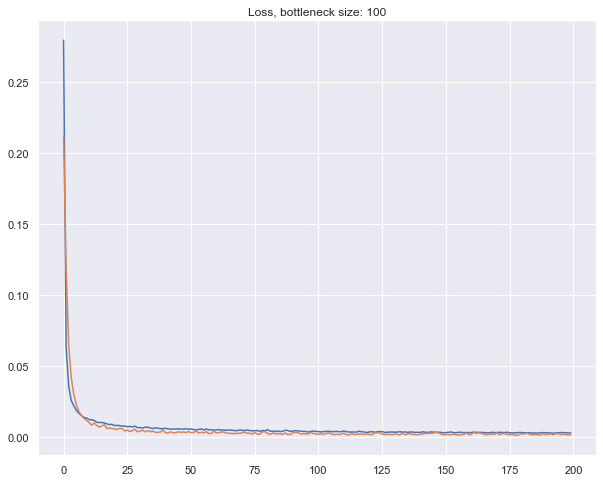

In [7]:
model.plot_loss(bottleneck_size = 100)

### Ερώτηση 1

> *Ποια είναι η διαφορά μεταξύ mini-batch και epochs;*

### Απάντηση

Η διαφορά μεταξύ *mini_batch* και *epochs* είναι η εξής: Μια εποχή αναφέρεται σε ένα πέρασμα του συνόλου δεδομένων κατά τη διάρκεια εκπαίδευσης του μοντέλου ενώ το *mini_batch* είναι το μέγεθος των υποσυνόλων του συνολικού συνόλου δεδομένων στο οποίο το έχουμε χωρίσει κατά τη διάρκεια μιας εποχής. Για παράδειγμα, αν έχουμε ένα σύνολο δεδομένων το οποίο αποτελείται από 10000 δείγματα και έχουμε *mini_batch* μέγεθος ίσο με 100, τότε αντί κατά τη διαδικασία εκπαίδευσης να «περνάμε» ένα-ένα τα δείγματα και να υπολογίζουμε το σφάλμα αυτό που κάνουμε είναι να τα «περνάμε» σε 100-άδες. Επομένως, οι ανανεώσεις των βαρών κατά τη διάρκεια αυτής της εποχής θα είναι 10000/100 = 100.

### Ερώτηση 2 & 3

> *Δοκιμάστε να τρέξετε το μοντέλο με Bottleneck: α) 50 και β) 25. Τι παρατηρείτε ως προς τα αποτελέσματα του μοντέλου; Δοκιμάστε να βάλετε τρία επίπεδα (τα δύο υφιστάμενα και ένα ακόμα με bottleneck 50). Τι διαφορές παρατηρείτε;*

### Απάντηση

Παρακάτω βλέπουμε τα αντίστοιχα αποτελέσματα του *encoder* με μέγεθος *bottleneck* 50 και 25 αντίστοιχα. Η αλλαγή του μεγέθους του *bottleneck* γίνεται μέσω της μεταβλητής `bottleneck` του *constructor* της κλάσης *custom_autoencoder*

#### A. *Bottleneck size = 50*

In [8]:
# A) Bottleneck size = 50

model = custom_autoencoder(num_input = n_inputs, bottleneck = 50, dim_layers = [2*n_inputs, n_inputs])
# fit the autoencoder model to reconstruct input
model.fit(X_train, X_test, epochs = 200, batch_size = 16, verbose =2)

Epoch 1/200
42/42 - 1s - loss: 0.2882 - val_loss: 0.2097 - 1s/epoch - 28ms/step
Epoch 2/200
42/42 - 0s - loss: 0.0613 - val_loss: 0.1214 - 125ms/epoch - 3ms/step
Epoch 3/200
42/42 - 0s - loss: 0.0337 - val_loss: 0.0694 - 123ms/epoch - 3ms/step
Epoch 4/200
42/42 - 0s - loss: 0.0253 - val_loss: 0.0400 - 124ms/epoch - 3ms/step
Epoch 5/200
42/42 - 0s - loss: 0.0214 - val_loss: 0.0307 - 122ms/epoch - 3ms/step
Epoch 6/200
42/42 - 0s - loss: 0.0186 - val_loss: 0.0234 - 124ms/epoch - 3ms/step
Epoch 7/200
42/42 - 0s - loss: 0.0179 - val_loss: 0.0195 - 137ms/epoch - 3ms/step
Epoch 8/200
42/42 - 0s - loss: 0.0161 - val_loss: 0.0149 - 140ms/epoch - 3ms/step
Epoch 9/200
42/42 - 0s - loss: 0.0160 - val_loss: 0.0134 - 122ms/epoch - 3ms/step
Epoch 10/200
42/42 - 0s - loss: 0.0144 - val_loss: 0.0119 - 123ms/epoch - 3ms/step
Epoch 11/200
42/42 - 0s - loss: 0.0133 - val_loss: 0.0101 - 121ms/epoch - 3ms/step
Epoch 12/200
42/42 - 0s - loss: 0.0122 - val_loss: 0.0106 - 122ms/epoch - 3ms/step
Epoch 13/200
42

Epoch 100/200
42/42 - 0s - loss: 0.0044 - val_loss: 0.0028 - 124ms/epoch - 3ms/step
Epoch 101/200
42/42 - 0s - loss: 0.0044 - val_loss: 0.0025 - 123ms/epoch - 3ms/step
Epoch 102/200
42/42 - 0s - loss: 0.0037 - val_loss: 0.0014 - 124ms/epoch - 3ms/step
Epoch 103/200
42/42 - 0s - loss: 0.0039 - val_loss: 0.0021 - 122ms/epoch - 3ms/step
Epoch 104/200
42/42 - 0s - loss: 0.0040 - val_loss: 0.0015 - 123ms/epoch - 3ms/step
Epoch 105/200
42/42 - 0s - loss: 0.0041 - val_loss: 0.0024 - 124ms/epoch - 3ms/step
Epoch 106/200
42/42 - 0s - loss: 0.0043 - val_loss: 0.0023 - 123ms/epoch - 3ms/step
Epoch 107/200
42/42 - 0s - loss: 0.0039 - val_loss: 0.0016 - 119ms/epoch - 3ms/step
Epoch 108/200
42/42 - 0s - loss: 0.0038 - val_loss: 0.0018 - 123ms/epoch - 3ms/step
Epoch 109/200
42/42 - 0s - loss: 0.0040 - val_loss: 0.0023 - 123ms/epoch - 3ms/step
Epoch 110/200
42/42 - 0s - loss: 0.0041 - val_loss: 0.0019 - 122ms/epoch - 3ms/step
Epoch 111/200
42/42 - 0s - loss: 0.0039 - val_loss: 0.0019 - 123ms/epoch - 3

Epoch 198/200
42/42 - 0s - loss: 0.0030 - val_loss: 0.0018 - 125ms/epoch - 3ms/step
Epoch 199/200
42/42 - 0s - loss: 0.0034 - val_loss: 0.0011 - 122ms/epoch - 3ms/step
Epoch 200/200
42/42 - 0s - loss: 0.0032 - val_loss: 0.0012 - 119ms/epoch - 3ms/step


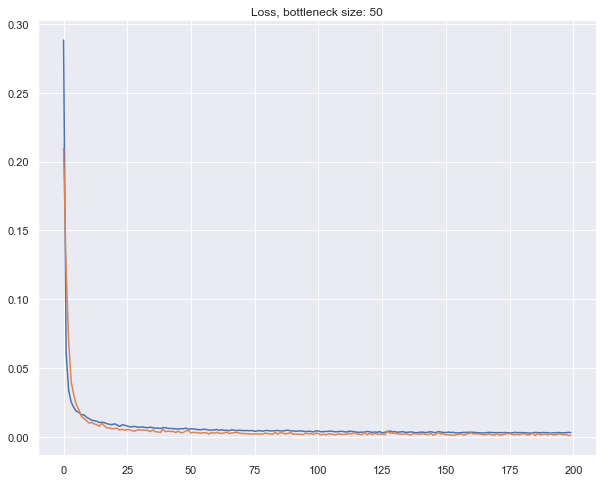

In [9]:
model.plot_loss(bottleneck_size = 50)

Κοιτώντας τις τιμές του *validation loss* για τις δύο προηγούμενες περιπτώσεις δεν φαίνεται κάποια σημαντική διαφορά. Αυτό που αναμένουμε όμως να συμβεί μειώνοντας το μέγεθος του *bottlenck* είναι να έχουμε αύξησει του *validation error*. Αυτό αναμένουμε να συμβεί γιατί μείωση στο μέγεθος του *bottleneck* αντιστοιχεί και σε μεγαλύτερη συμπίεση του συνόλου δεδομένων, έτσι όσο περισσότερο συμπιέζουμε τα δεδομένα μας τόσο πιο δύσκολο είναι και να τα ανακτήσουμε στην αρχική τους κατάσταση κατά τη διάρκεια της αποκωδικοποίησης. Παρακάτω βλέπουμε και τα αποτελέσματα για μέγεθος *bottleneck* ίσο με 25.

#### B. *Bottleneck size = 25*

In [10]:
#### B. *Bottleneck size = 25*

model = custom_autoencoder(num_input = n_inputs, bottleneck = 25, dim_layers = [2*n_inputs, n_inputs])
# fit the autoencoder model to reconstruct input
model.fit(X_train, X_test, epochs = 200, batch_size = 16, verbose =2)

Epoch 1/200
42/42 - 1s - loss: 0.2638 - val_loss: 0.1956 - 1s/epoch - 32ms/step
Epoch 2/200
42/42 - 0s - loss: 0.0511 - val_loss: 0.1102 - 122ms/epoch - 3ms/step
Epoch 3/200
42/42 - 0s - loss: 0.0302 - val_loss: 0.0628 - 135ms/epoch - 3ms/step
Epoch 4/200
42/42 - 0s - loss: 0.0232 - val_loss: 0.0391 - 126ms/epoch - 3ms/step
Epoch 5/200
42/42 - 0s - loss: 0.0196 - val_loss: 0.0252 - 124ms/epoch - 3ms/step
Epoch 6/200
42/42 - 0s - loss: 0.0174 - val_loss: 0.0203 - 120ms/epoch - 3ms/step
Epoch 7/200
42/42 - 0s - loss: 0.0162 - val_loss: 0.0166 - 123ms/epoch - 3ms/step
Epoch 8/200
42/42 - 0s - loss: 0.0146 - val_loss: 0.0143 - 120ms/epoch - 3ms/step
Epoch 9/200
42/42 - 0s - loss: 0.0137 - val_loss: 0.0133 - 124ms/epoch - 3ms/step
Epoch 10/200
42/42 - 0s - loss: 0.0140 - val_loss: 0.0117 - 122ms/epoch - 3ms/step
Epoch 11/200
42/42 - 0s - loss: 0.0129 - val_loss: 0.0104 - 130ms/epoch - 3ms/step
Epoch 12/200
42/42 - 0s - loss: 0.0118 - val_loss: 0.0101 - 131ms/epoch - 3ms/step
Epoch 13/200
42

Epoch 100/200
42/42 - 0s - loss: 0.0042 - val_loss: 0.0034 - 118ms/epoch - 3ms/step
Epoch 101/200
42/42 - 0s - loss: 0.0046 - val_loss: 0.0050 - 116ms/epoch - 3ms/step
Epoch 102/200
42/42 - 0s - loss: 0.0043 - val_loss: 0.0022 - 116ms/epoch - 3ms/step
Epoch 103/200
42/42 - 0s - loss: 0.0042 - val_loss: 0.0022 - 118ms/epoch - 3ms/step
Epoch 104/200
42/42 - 0s - loss: 0.0044 - val_loss: 0.0024 - 122ms/epoch - 3ms/step
Epoch 105/200
42/42 - 0s - loss: 0.0042 - val_loss: 0.0019 - 116ms/epoch - 3ms/step
Epoch 106/200
42/42 - 0s - loss: 0.0042 - val_loss: 0.0024 - 117ms/epoch - 3ms/step
Epoch 107/200
42/42 - 0s - loss: 0.0042 - val_loss: 0.0019 - 117ms/epoch - 3ms/step
Epoch 108/200
42/42 - 0s - loss: 0.0044 - val_loss: 0.0031 - 117ms/epoch - 3ms/step
Epoch 109/200
42/42 - 0s - loss: 0.0041 - val_loss: 0.0026 - 118ms/epoch - 3ms/step
Epoch 110/200
42/42 - 0s - loss: 0.0039 - val_loss: 0.0032 - 116ms/epoch - 3ms/step
Epoch 111/200
42/42 - 0s - loss: 0.0045 - val_loss: 0.0025 - 141ms/epoch - 3

Epoch 198/200
42/42 - 0s - loss: 0.0028 - val_loss: 0.0011 - 120ms/epoch - 3ms/step
Epoch 199/200
42/42 - 0s - loss: 0.0027 - val_loss: 0.0015 - 120ms/epoch - 3ms/step
Epoch 200/200
42/42 - 0s - loss: 0.0028 - val_loss: 0.0017 - 119ms/epoch - 3ms/step


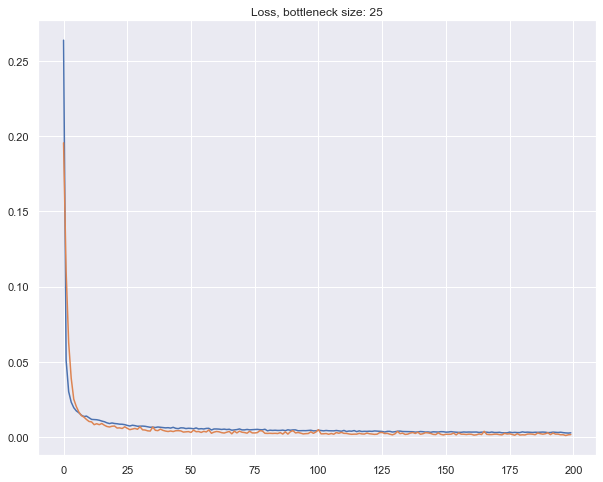

In [11]:
model.plot_loss(bottleneck_size = 25)

Όπως βλέπουμε και απ' τις παραπάνω μετρήσεις πάλι δεν βλέπουμε κάποια ουσιαστική διαφορά ως προς το σφάλμα εκπαίδευσης και επικύρωσης. Δοκιμάζουμε να μειώσουμε ακόμα περισσότερο το μέγεθος του *bottleneck* για να δούμε αν θα υπάρξει κάποια ουσιαστική διαφορά. Διαλέγουμε μέγεθος ίσο με 2.

#### Γ. *Bottleneck size = 2* 

In [17]:
#### Γ. *Bottleneck size = 2*

model = custom_autoencoder(num_input = n_inputs, bottleneck = 2, dim_layers = [2*n_inputs, n_inputs])
# fit the autoencoder model to reconstruct input
model.fit(X_train, X_test, epochs = 200, batch_size = 16, verbose =2)

Epoch 1/200
42/42 - 1s - loss: 0.1640 - val_loss: 0.1846 - 1s/epoch - 28ms/step
Epoch 2/200
42/42 - 0s - loss: 0.0339 - val_loss: 0.1035 - 124ms/epoch - 3ms/step
Epoch 3/200
42/42 - 0s - loss: 0.0262 - val_loss: 0.0578 - 118ms/epoch - 3ms/step
Epoch 4/200
42/42 - 0s - loss: 0.0226 - val_loss: 0.0416 - 120ms/epoch - 3ms/step
Epoch 5/200
42/42 - 0s - loss: 0.0221 - val_loss: 0.0301 - 131ms/epoch - 3ms/step
Epoch 6/200
42/42 - 0s - loss: 0.0208 - val_loss: 0.0257 - 159ms/epoch - 4ms/step
Epoch 7/200
42/42 - 0s - loss: 0.0197 - val_loss: 0.0234 - 153ms/epoch - 4ms/step
Epoch 8/200
42/42 - 0s - loss: 0.0201 - val_loss: 0.0221 - 150ms/epoch - 4ms/step
Epoch 9/200
42/42 - 0s - loss: 0.0190 - val_loss: 0.0203 - 164ms/epoch - 4ms/step
Epoch 10/200
42/42 - 0s - loss: 0.0187 - val_loss: 0.0186 - 133ms/epoch - 3ms/step
Epoch 11/200
42/42 - 0s - loss: 0.0189 - val_loss: 0.0176 - 126ms/epoch - 3ms/step
Epoch 12/200
42/42 - 0s - loss: 0.0180 - val_loss: 0.0182 - 148ms/epoch - 4ms/step
Epoch 13/200
42

Epoch 100/200
42/42 - 0s - loss: 0.0141 - val_loss: 0.0135 - 130ms/epoch - 3ms/step
Epoch 101/200
42/42 - 0s - loss: 0.0135 - val_loss: 0.0130 - 131ms/epoch - 3ms/step
Epoch 102/200
42/42 - 0s - loss: 0.0136 - val_loss: 0.0147 - 139ms/epoch - 3ms/step
Epoch 103/200
42/42 - 0s - loss: 0.0140 - val_loss: 0.0134 - 128ms/epoch - 3ms/step
Epoch 104/200
42/42 - 0s - loss: 0.0143 - val_loss: 0.0140 - 136ms/epoch - 3ms/step
Epoch 105/200
42/42 - 0s - loss: 0.0137 - val_loss: 0.0129 - 127ms/epoch - 3ms/step
Epoch 106/200
42/42 - 0s - loss: 0.0139 - val_loss: 0.0126 - 140ms/epoch - 3ms/step
Epoch 107/200
42/42 - 0s - loss: 0.0137 - val_loss: 0.0142 - 139ms/epoch - 3ms/step
Epoch 108/200
42/42 - 0s - loss: 0.0137 - val_loss: 0.0133 - 133ms/epoch - 3ms/step
Epoch 109/200
42/42 - 0s - loss: 0.0137 - val_loss: 0.0133 - 133ms/epoch - 3ms/step
Epoch 110/200
42/42 - 0s - loss: 0.0131 - val_loss: 0.0129 - 126ms/epoch - 3ms/step
Epoch 111/200
42/42 - 0s - loss: 0.0141 - val_loss: 0.0143 - 124ms/epoch - 3

Epoch 198/200
42/42 - 0s - loss: 0.0122 - val_loss: 0.0127 - 127ms/epoch - 3ms/step
Epoch 199/200
42/42 - 0s - loss: 0.0121 - val_loss: 0.0123 - 117ms/epoch - 3ms/step
Epoch 200/200
42/42 - 0s - loss: 0.0123 - val_loss: 0.0121 - 117ms/epoch - 3ms/step


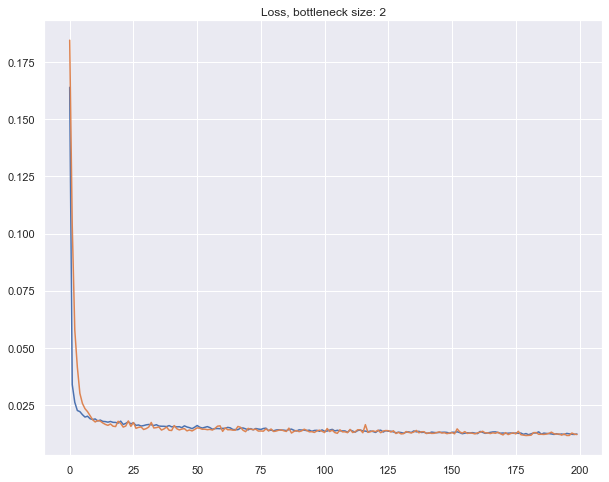

In [18]:
model.plot_loss(bottleneck_size = 2)

Τώρα κοιτώντας τις μετρήσεις για το σφάλμα εκπαίδευσης και επικύρωσης είναι εμφανής η διαφορά σε σχέση με τις περιπτώσεις που το μέγεθος του *bottleneck* ήταν 25 και 50. Όπως βλέπουμε στην περίπτωση που το *bottleneck size* είναι 2 το σφάλμα είναι της τάξης του $10^{-2}$* σε αντίθεση με τις προηγούμενες δύο περιπτώσεις που ήταν της τάξης του $10^{-3}$. Λαμβάνοντας υπ'όψιν ότι έχουμε προεπεξεργαστεί τα δεδομένα μας έχοντας απεικονίσει τις τιμές στο $[0,1]$ η διαφορα δύο τιμών στο $[0,1]$ είναι έτσι και αλλιώς της τάξης του $10^{-1}$, άρα το μέσο τετραγωνικό σφάλμα θα είναι έτσι και αλλιώς της τάξης του $10^{-2}$. Συνεπώς, στην περίπτωση που έχουμε μέγεθος *bottleneck* ίσο με 2 δεν έχουμε καθόλου καλή αποκωδικοποίηση των δεδομένων μετά τη συμπίεση.

#### Δ. 3 Κρυφά επίπεδα + Bottleneck μεγέθους 50

Τέλος, προσθέτουμε και ένα ακόμα επίπεδο διάστασης 200 και *bottleneck* διάστασης 50 και καταγράφουμε τα αποτελέσματα και γι'αυτή την περίπτωση.

In [20]:
#### Γ. *Bottleneck size = 50*

model = custom_autoencoder(num_input = n_inputs, bottleneck = 50, dim_layers = [2*n_inputs, n_inputs, 2*n_inputs]) # 3 hidden layer
# fit the autoencoder model to reconstruct input
model.fit(X_train, X_test, epochs = 200, batch_size = 16, verbose =2)

Epoch 1/200
42/42 - 2s - loss: 0.2881 - val_loss: 0.1935 - 2s/epoch - 41ms/step
Epoch 2/200
42/42 - 0s - loss: 0.0573 - val_loss: 0.1054 - 163ms/epoch - 4ms/step
Epoch 3/200
42/42 - 0s - loss: 0.0322 - val_loss: 0.0583 - 159ms/epoch - 4ms/step
Epoch 4/200
42/42 - 0s - loss: 0.0236 - val_loss: 0.0407 - 155ms/epoch - 4ms/step
Epoch 5/200
42/42 - 0s - loss: 0.0200 - val_loss: 0.0269 - 156ms/epoch - 4ms/step
Epoch 6/200
42/42 - 0s - loss: 0.0185 - val_loss: 0.0244 - 157ms/epoch - 4ms/step
Epoch 7/200
42/42 - 0s - loss: 0.0167 - val_loss: 0.0196 - 159ms/epoch - 4ms/step
Epoch 8/200
42/42 - 0s - loss: 0.0157 - val_loss: 0.0155 - 165ms/epoch - 4ms/step
Epoch 9/200
42/42 - 0s - loss: 0.0160 - val_loss: 0.0145 - 164ms/epoch - 4ms/step
Epoch 10/200
42/42 - 0s - loss: 0.0144 - val_loss: 0.0133 - 162ms/epoch - 4ms/step
Epoch 11/200
42/42 - 0s - loss: 0.0139 - val_loss: 0.0113 - 162ms/epoch - 4ms/step
Epoch 12/200
42/42 - 0s - loss: 0.0135 - val_loss: 0.0106 - 164ms/epoch - 4ms/step
Epoch 13/200
42

Epoch 100/200
42/42 - 0s - loss: 0.0043 - val_loss: 0.0030 - 177ms/epoch - 4ms/step
Epoch 101/200
42/42 - 0s - loss: 0.0044 - val_loss: 0.0025 - 171ms/epoch - 4ms/step
Epoch 102/200
42/42 - 0s - loss: 0.0042 - val_loss: 0.0021 - 171ms/epoch - 4ms/step
Epoch 103/200
42/42 - 0s - loss: 0.0044 - val_loss: 0.0021 - 157ms/epoch - 4ms/step
Epoch 104/200
42/42 - 0s - loss: 0.0041 - val_loss: 0.0021 - 153ms/epoch - 4ms/step
Epoch 105/200
42/42 - 0s - loss: 0.0040 - val_loss: 0.0021 - 153ms/epoch - 4ms/step
Epoch 106/200
42/42 - 0s - loss: 0.0045 - val_loss: 0.0023 - 153ms/epoch - 4ms/step
Epoch 107/200
42/42 - 0s - loss: 0.0040 - val_loss: 0.0021 - 159ms/epoch - 4ms/step
Epoch 108/200
42/42 - 0s - loss: 0.0043 - val_loss: 0.0036 - 152ms/epoch - 4ms/step
Epoch 109/200
42/42 - 0s - loss: 0.0042 - val_loss: 0.0032 - 159ms/epoch - 4ms/step
Epoch 110/200
42/42 - 0s - loss: 0.0045 - val_loss: 0.0026 - 155ms/epoch - 4ms/step
Epoch 111/200
42/42 - 0s - loss: 0.0045 - val_loss: 0.0023 - 164ms/epoch - 4

Epoch 198/200
42/42 - 0s - loss: 0.0029 - val_loss: 0.0021 - 153ms/epoch - 4ms/step
Epoch 199/200
42/42 - 0s - loss: 0.0029 - val_loss: 0.0019 - 170ms/epoch - 4ms/step
Epoch 200/200
42/42 - 0s - loss: 0.0031 - val_loss: 0.0025 - 165ms/epoch - 4ms/step


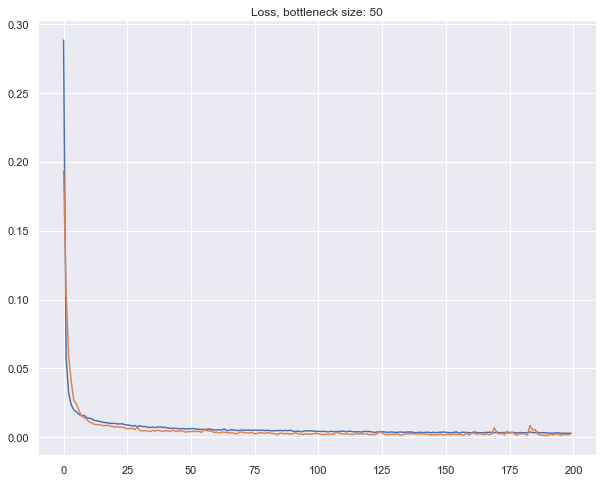

In [21]:
model.plot_loss(bottleneck_size = 50)

Όπως βλέπουμε και σε αυτή την περίπτωση το σφάλμα είναι της τάξης του $10^{-3}$ και έτσι μπορούμε να συμπεράνουμε ότι η προσθήκη του extra κρυφού επιπέδου δεν επηρέασε σημαντικά το αποτέλεσμα σε σχέση με την περίπτωση των δύο κρυφών επιπέδων με αντίστοιχα μεγέθη *bottleneck*.